TODO:
* visualization
* feature engineering OK
* cross validation OK
* grid search OK
* stratification
* understand auc OK
* docker image
* advice on kaggle OK
* understand boosting
* neural network
* pandas warning
* xgboost OK
* outliers
* remove when unknown ??
* clean data
* make sure it works when rerun from scratch
* feature selection NOT HELPING

In [1]:
!ls

bank-classification.csv  mnist_cnn.ipynb    README.md
experiments.ipynb	 my_submission.csv  sample_submission.csv


In [2]:
!head sample_submission.csv

id,y
2,0.114428578297
4,0.114428578297
5,0.114428578297
7,0.114428578297
10,0.114428578297
12,0.114428578297
14,0.114428578297
16,0.114428578297
18,0.114428578297


In [148]:
import pandas as pd
df = pd.read_csv('bank-classification.csv')
# It's important to shuffle the data
df = df.sample(frac=1, replace=False, random_state=42)
print(df[:5])

          id  birth_date          job  marital    education  default housing  \
32884  32885  1952-07-15   technician  married  high.school       no      no   
3169    3170  1953-06-30      unknown  married      unknown  unknown     yes   
32206  32207  1976-09-12  blue-collar  married     basic.9y       no      no   
9403    9404  1972-04-10       admin.  married  high.school       no      no   
14020  14021  1981-05-25    housemaid  married  high.school       no     yes   

      loan contact_date    contact  campaign  pdays  previous     poutcome  \
32884  yes   2009-05-04   cellular         1    999         1      failure   
3169    no   2008-05-08  telephone         2    999         0  nonexistent   
32206   no   2009-05-08   cellular         1    999         1      failure   
9403    no   2008-06-27  telephone         4    999         0  nonexistent   
14020   no   2008-07-25   cellular         2    999         0  nonexistent   

             y  
32884  unknown  
3169   unknown  

### Let's split training and test sets.

In [4]:
train_df = df.loc[df['y'] != 'unknown']
test_df = df.loc[df['y'] == 'unknown']

In [5]:
train_df.loc[:, 'y'] = train_df.loc[:, 'y'].map({'no': 0, 'yes': 1})

/home/michal/Pulpit/jnp_ml/mlenv/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Let's make sure it works despite warning

In [8]:
train_df['y'][:5]

32206    0
9403     0
17201    0
23757    0
16735    0
Name: y, dtype: int64

### Let's examine the proportion of yes/no labels in training set

In [150]:
pd.value_counts(train_df.y)

0    18419
1     2380
Name: y, dtype: int64

In [30]:
def get_year(date):
    year_str = date[:4]
    year = int(year_str)
    return year

def get_month(date):
    month_str = date[5:7]
    month = int(month_str)
    return month

def get_year_and_month(date):
    return get_year(date), get_month(date)

### Let's look at the job distribution and the probabilities.

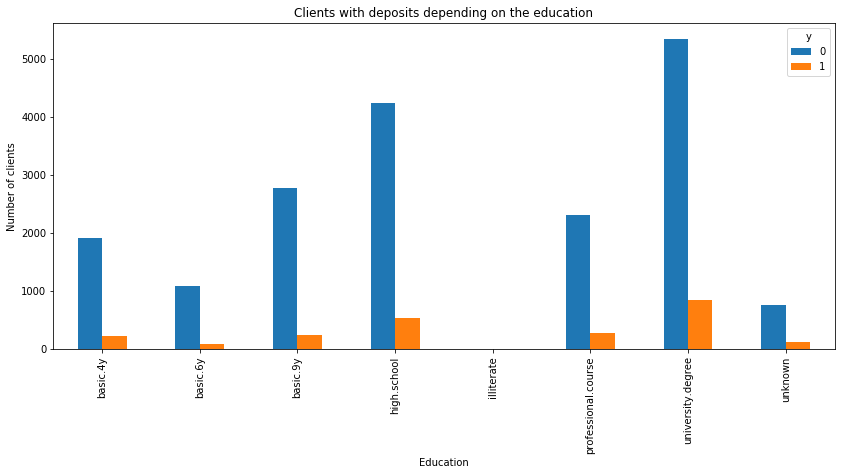

In [184]:
import matplotlib.pyplot as plt
pd.crosstab(train_df.education, train_df.y).plot(kind='bar', figsize=(14, 6))
plt.title('Clients with deposits depending on the education')
plt.xlabel('Education')
plt.ylabel('Number of clients')
plt.show()

### Let's check if the distributions are equal on train and test sets

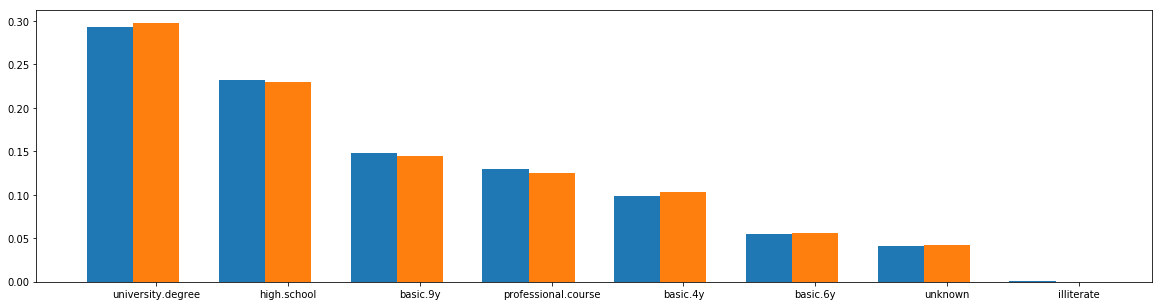

In [183]:
education_test = pd.value_counts(test_df.education) / len(test_df)
education_train = pd.value_counts(train_df.education) / len(train_df)
plt.figure(figsize=(20, 5))
bar_width = 0.35
n_groups = len(education_test.keys())
index = np.arange(n_groups)
plt.bar(index, education_test, bar_width)
plt.bar(index + bar_width, education_train, bar_width)
plt.xticks(index + bar_width, education_test.keys())
plt.show()

### Let's examine the medium chance of a deposit subscription regarding the education.

In [147]:
education_means = train_df.get(['education', 'y']).groupby(['education']).mean()
print(education_means)

                            y
education                    
basic.4y             0.109099
basic.6y             0.076068
basic.9y             0.082891
high.school          0.112738
illiterate           0.142857
professional.course  0.110340
university.degree    0.137435
unknown              0.145434


### Let's examine the same for profession.

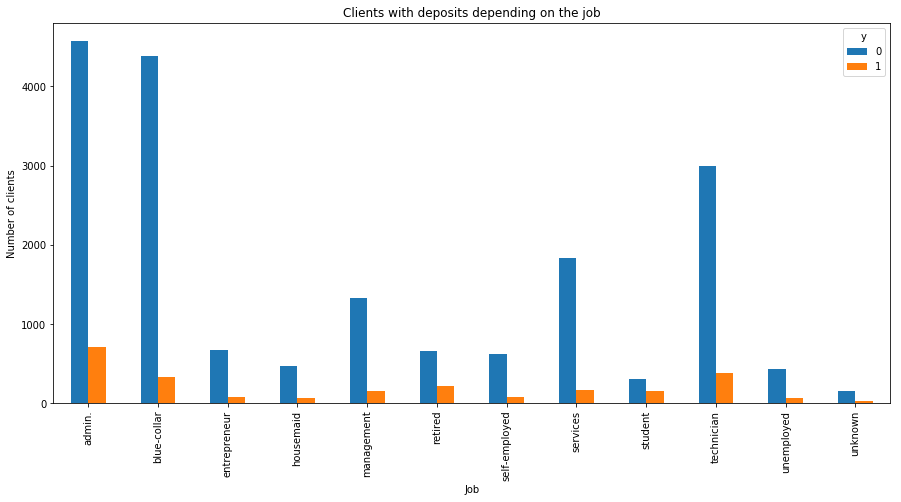

In [180]:
import matplotlib.pyplot as plt
pd.crosstab(train_df.job, train_df.y).plot(kind='bar', figsize=(15, 7))
plt.title('Clients with deposits depending on the job')
plt.xlabel('Job')
plt.ylabel('Number of clients')
plt.show()

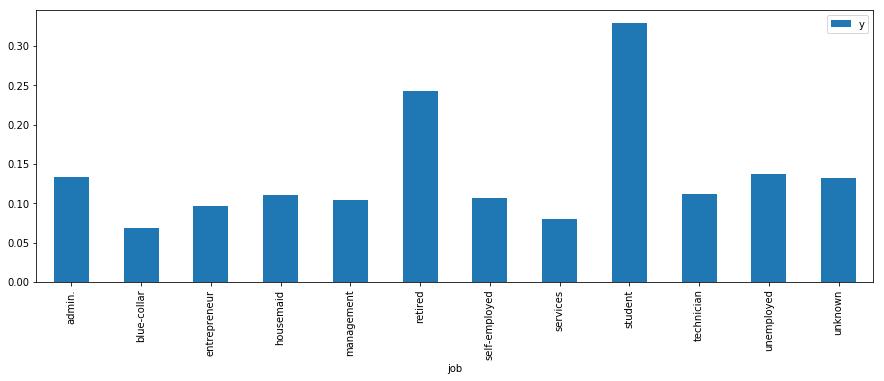

In [182]:
job_means = train_df.get(['job', 'y']).groupby(['job']).mean()
job_means.plot(kind='bar', figsize=(15, 5))
plt.show()

Type of contact is correlated with the final decision.

In [152]:
print(pd.value_counts(train_df.contact))
print(train_df.get(['y', 'contact']).groupby(['contact']).mean())

cellular     13212
telephone     7587
Name: contact, dtype: int64
                  y
contact            
cellular   0.149864
telephone  0.052722


In [50]:
mapping = train_df.get(['previous', 'y']).groupby(['previous']).agg(np.mean)
mapping_dict = dict(zip(range(8), mapping.y))
print(mapping_dict)
previous_transformed = train_df.previous.map(mapping_dict)

{0: 0.089807039982205419, 1: 0.21616871704745166, 2: 0.48186528497409326, 3: 0.59459459459459463, 4: 0.46875, 5: 0.7142857142857143, 6: 0.33333333333333331, 7: 0.0}


In [51]:
mapping = train_df.get(['poutcome', 'y']).groupby(['poutcome']).agg(np.mean)
mapping_dict = dict(zip(['failure', 'nonexistent', 'success'], mapping.y))
print(mapping_dict)
poutcome_transformed = train_df.poutcome.map(mapping_dict)
import matplotlib.pyplot as plt
print(poutcome_transformed)


{'nonexistent': 0.089807039982205419, 'success': 0.65527488855869243, 'failure': 0.15118992067195519}
32206    0.151190
9403     0.089807
17201    0.089807
23757    0.089807
16735    0.089807
8040     0.089807
14064    0.089807
17688    0.089807
17267    0.089807
8528     0.089807
33728    0.089807
36968    0.089807
36562    0.089807
40868    0.089807
11042    0.089807
23685    0.089807
8725     0.089807
28062    0.151190
6314     0.089807
12357    0.089807
12515    0.089807
23461    0.089807
6108     0.089807
32668    0.151190
2464     0.089807
33789    0.655275
12893    0.089807
39196    0.655275
29731    0.089807
27101    0.089807
           ...   
13417    0.089807
1021     0.089807
19457    0.089807
23939    0.089807
3943     0.089807
26531    0.089807
35920    0.151190
14541    0.089807
40994    0.655275
17159    0.089807
23897    0.089807
11016    0.089807
14502    0.089807
30740    0.151190
3556     0.089807
1267     0.089807
1899     0.089807
19118    0.089807
18431    0.08980

In [52]:
train_df.get(['id', 'marital']).groupby(['marital']).count()

,id
marital,
divorced,2347
married,12512
single,5896
unknown,44


In [53]:
import datetime

def get_weekday(date_str):
    year, month, day = [int(item) for item in date_str.split('-')]
    return datetime.datetime(year, month, day).weekday()

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def get_categorical(column):
    le = LabelEncoder()
    le.fit(column)
    labeled_column = le.transform(column)
    return to_categorical(labeled_column).T

def get_input_data(df):
    ages = get_categorical([(get_year(contact) - get_year(birth)) // 10 for contact, birth in
                     zip(df['contact_date'], df['birth_date'])])
    
    jobs = get_categorical(df['job'])
    education = get_categorical(df['education'])
    marital = get_categorical(df['marital'])
    loan = get_categorical(df['loan'])
    default = get_categorical(df['default'])
    housing = get_categorical(df['housing'])
    contact_years = [get_year(contact) - 2008 for contact in df['contact_date']]
    contact_months = get_categorical([get_month(contact) for contact in df['contact_date']])
    contact = get_categorical(contact_years)
    poutcome = get_categorical(df['poutcome'])
    campaign = get_categorical(df['campaign'])
    previous = np.array([df['previous']])
    contact_type = np.array([df['contact'] == 'cellular'])
    pdays = np.array([np.array(df['pdays'].isin(range(3)), dtype=int), 
                      np.array(df['pdays'].isin (range(3, 6)), dtype=int), 
                      np.array(df['pdays'].isin (range(6, 10)), dtype=int),
                      np.array(df['pdays'].isin (range(10, 28)), dtype=int),
                      np.array(df['pdays'] == 999, dtype=int)])
    
    new_len = pdays.shape[0] * poutcome.shape[0]
    days_outcome = np.empty((new_len, pdays.shape[1]))
    for i in range(pdays.shape[0]):
        for j in range(poutcome.shape[0]):
            days_outcome[i * poutcome.shape[0] + j] = pdays[i] * poutcome[j]    
        
    contact_weekday = get_categorical(np.array(df['contact_date'].map(get_weekday)))
    contact_combined_year_month = get_categorical(df['contact_date'].map(get_year_and_month))
    return np.concatenate([ages, jobs, education, marital, default, contact, poutcome,
                           campaign, previous, contact_type, pdays,
                          #np.array([df['previous'] - df['campaign']]),
                        #np.array([df['previous'] + df['campaign']]),
                        #np.array([df['previous'] / df['campaign']]),
                        contact_months,
                        contact_weekday,
                           contact_combined_year_month,
                           #days_outcome
                          ], axis=0).T, np.array(df['y'])

In [55]:
train_df.get(['id', 'pdays']).groupby(['pdays']).count()


,id
pdays,
0,7
1,10
2,30
3,214
4,54
5,21
6,216
7,26
8,10


In [56]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV 
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


base = LogisticRegression(C=0.8) 
classifier = XGBClassifier(n_estimators=30, subsample=1.0, scale_pos_weight=1.)
#classifier = SVC(class_weight='balanced', probability=True, verbose=2, random_state=42, kernel='linear')
#classifier = AdaBoostClassifier(base_estimator=base)
X, y = get_input_data(train_df)
print(X, y)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]] [0 0 0 ..., 0 0 0]


In [57]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X, y)

In [58]:
#from sklearn.feature_selection import SelectPercentile
#X = SelectPercentile(percentile=80).fit_transform(X, y)

In [59]:
from sklearn.model_selection import GridSearchCV
#parameters = {'n_estimators': [30, 50, 100], 'scale_pos_weight': [0.1, 0.3, 1., 2., 5.], 
#              'learning_rate': [0.08, 0.1, 0.12], 'subsample': [0.7, 0.9, 1.0]}
parameters = {}
parameters = {'n_estimators': [30], 'subsample': [0.9], 'learning_rate': [0.12], 'scale_pos_weight': [2.0]}
grid_classifier = GridSearchCV(classifier, parameters, scoring='roc_auc', cv=10, n_jobs=1, verbose=10)

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
grid_classifier.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9 
[CV]  learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9, score=0.774822306772872, total=   0.5s
[CV] learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9, score=0.7763688537304172, total=   0.6s
[CV] learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9, score=0.8058444876321864, total=   0.6s
[CV] learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s


[CV]  learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9, score=0.804539731201927, total=   0.6s
[CV] learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s


[CV]  learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9, score=0.770338917325888, total=   0.5s
[CV] learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s remaining:    0.0s


[CV]  learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9, score=0.7835689650453015, total=   0.6s
[CV] learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.6s remaining:    0.0s


[CV]  learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9, score=0.7835233441910967, total=   0.6s
[CV] learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.2s remaining:    0.0s


[CV]  learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9, score=0.8203747296964388, total=   0.6s
[CV] learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.8s remaining:    0.0s


[CV]  learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9, score=0.8150815700873184, total=   0.6s
[CV] learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.5s remaining:    0.0s


[CV]  learning_rate=0.12, n_estimators=30, scale_pos_weight=2.0, subsample=0.9, score=0.7677938095390248, total=   0.6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.1s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=30, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1.0, seed=0, silent=True, subsample=1.0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.12], 'n_estimators': [30], 'scale_pos_weight': [2.0], 'subsample': [0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [61]:
print(grid_classifier.best_score_, grid_classifier.best_params_)
best_classifier = grid_classifier.best_estimator_

0.790226750029 {'learning_rate': 0.12, 'n_estimators': 30, 'scale_pos_weight': 2.0, 'subsample': 0.9}


In [59]:
best_classifier.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.12, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=30, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=2.0, seed=0, silent=True, subsample=0.9)

In [60]:
best_classifier.feature_importances_

array([ 0.        ,  0.00478469,  0.        ,  0.02870813,  0.00478469,
        0.00478469,  0.01435407,  0.        ,  0.        ,  0.02392345,
        0.01913876,  0.00478469,  0.        ,  0.        ,  0.00478469,
        0.        ,  0.00478469,  0.00478469,  0.        ,  0.        ,
        0.01435407,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00956938,  0.        ,  0.01435407,  0.00478469,  0.01435407,
        0.00956938,  0.00956938,  0.        ,  0.        ,  0.10047847,
        0.01913876,  0.02392345,  0.03349282,  0.00478469,  0.01913876,
        0.        ,  0.        ,  0.00478469,  0.00478469,  0.00956938,
        0.00478469,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00478469,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [61]:
from pandas import DataFrame

def return_submission(classifier, path, test_df):
    X_test, _ = get_input_data(test_df)
    predictions = classifier.predict_proba(X_test)
    results_pd = DataFrame({'id': test_df['id'], 'y': predictions[::, 1]})
    results_pd = results_pd.sort_values('id')
    results_pd.to_csv(path, index=False)

return_submission(best_classifier, 'my_submission.csv', test_df)

In [62]:
!head my_submission.csv
!tail my_submission.csv

id,y
2,0.07659514248371124
4,0.07659514248371124
5,0.07659514248371124
7,0.07659514248371124
10,0.07659514248371124
12,0.07659514248371124
14,0.07659514248371124
16,0.07223605364561081
18,0.07659514248371124
41171,0.516089141368866
41172,0.4590745270252228
41174,0.5311034917831421
41175,0.8450337648391724
41178,0.6457563638687134
41180,0.6594027280807495
41181,0.6457563638687134
41184,0.6457563638687134
41185,0.6199942827224731
41187,0.6457563638687134
